### Get a simple GCN Working

In [4]:
import torch
import pickle
import numpy as np
import networkx as nx
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.loader import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Load data splits
# dataset = 'fer2013'
dataset = 'ck'
train_data_path = dataset + '_data/train_data_70_20_10.pkl'
val_data_path = dataset + '_data/val_data_70_20_10.pkl'
test_data_path = dataset + '_data/test_data_70_20_10.pkl'

with open(train_data_path, 'rb') as f:
    train_data = pickle.load(f)
with open(val_data_path, 'rb') as f:
    val_data = pickle.load(f)
with open(test_data_path, 'rb') as f:
    test_data = pickle.load(f)

adjacency_matrix = np.loadtxt('standard_mesh_adj_matrix.csv', delimiter=',')
G = nx.from_numpy_array(adjacency_matrix)

# Add batch attribute to each data object
for data in train_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in val_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)
for data in test_data:
    data.batch = torch.zeros(data.x.size(0), dtype=torch.long)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [5]:
class SimpleGCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGCN, self).__init__()
        nn1 = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINConv(nn1)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        nn2 = torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(), torch.nn.Linear(hidden_dim, hidden_dim))
        self.conv2 = GINConv(nn2)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x.to(torch.float), data.edge_index.to(torch.int64), data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return F.log_softmax(x, dim=1)

# Convert data lists to DataLoader
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the training and evaluation functions
def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += pred.eq(data.y).sum().item()
        total += data.y.size(0)
    return total_loss / len(train_loader), correct / total

def evaluate(loader):
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += pred.eq(data.y).sum().item()
            total += data.y.size(0)
            val_loss += criterion(out, data.y).item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
    return correct / total, val_loss / len(loader), all_labels, all_preds

# Get number of classes
output_dim = len(np.unique([data.y.item() for data in train_data]))

# Initialize model, optimizer, and criterion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleGCN(input_dim=3, hidden_dim=64, output_dim=output_dim).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Calculate class weights
label_counts = np.bincount([data.y.item() for data in train_data])
class_weights = 1.0 / label_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

early_stopping = EarlyStopping(patience=20, delta=0.001)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(1, 501):
    train_loss, train_acc = train()
    val_acc, val_loss, _, _ = evaluate(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Train Acc: {int(100 * train_acc):02d}%, Val Acc: {int(100 * val_acc):02d}%')
    
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 001, Train Loss: 2.1343, Val Loss: 2.0759, Train Acc: 22%, Val Acc: 21%
Epoch: 002, Train Loss: 2.0773, Val Loss: 2.0768, Train Acc: 17%, Val Acc: 28%
Epoch: 003, Train Loss: 2.0848, Val Loss: 2.0858, Train Acc: 20%, Val Acc: 20%
Epoch: 004, Train Loss: 2.0801, Val Loss: 2.0862, Train Acc: 17%, Val Acc: 11%
Epoch: 005, Train Loss: 2.0844, Val Loss: 2.0770, Train Acc: 26%, Val Acc: 19%
Epoch: 006, Train Loss: 2.0889, Val Loss: 2.0783, Train Acc: 19%, Val Acc: 19%
Epoch: 007, Train Loss: 2.0795, Val Loss: 2.0772, Train Acc: 27%, Val Acc: 26%
Epoch: 008, Train Loss: 2.0820, Val Loss: 2.0804, Train Acc: 21%, Val Acc: 17%
Epoch: 009, Train Loss: 2.0881, Val Loss: 2.0823, Train Acc: 24%, Val Acc: 16%
Epoch: 010, Train Loss: 2.0713, Val Loss: 2.0718, Train Acc: 16%, Val Acc: 16%
Epoch: 011, Train Loss: 2.0650, Val Loss: 2.0657, Train Acc: 16%, Val Acc: 16%
Epoch: 012, Train Loss: 2.0872, Val Loss: 2.0674, Train Acc: 16%, Val Acc: 16%
Epoch: 013, Train Loss: 2.0817, Val Loss: 2.0655, Tr

<All keys matched successfully>

Test Accuracy: 53.33%


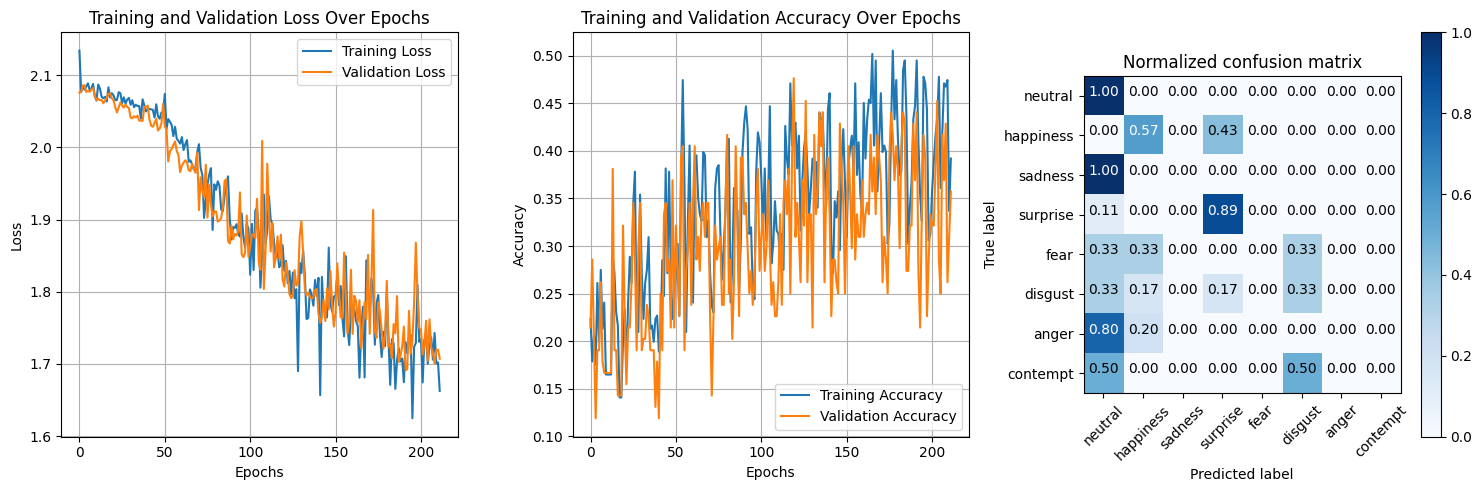

              precision    recall  f1-score    support
neutral        0.454545  1.000000  0.625000  10.000000
happiness      0.571429  0.571429  0.571429   7.000000
sadness        0.000000  0.000000  0.000000   3.000000
surprise       0.666667  0.888889  0.761905   9.000000
fear           0.000000  0.000000  0.000000   3.000000
disgust        0.500000  0.333333  0.400000   6.000000
anger          0.000000  0.000000  0.000000   5.000000
contempt       0.000000  0.000000  0.000000   2.000000
accuracy       0.533333  0.533333  0.533333   0.533333
macro avg      0.274080  0.349206  0.294792  45.000000
weighted avg   0.389899  0.533333  0.433492  45.000000


In [6]:
# Evaluation on test set
test_acc, test_loss, test_labels, test_preds = evaluate(test_loader)
print(f'Test Accuracy: {100 * test_acc:.2f}%')

plt.figure(figsize=(20, 5))

# Plotting training and validation loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Plotting training and validation accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

if dataset == 'ck':
    label_mapping = {'neutral': 0, 'happiness': 1, 'sadness': 2, 'surprise': 3, 'fear': 4, 'disgust': 5, 'anger': 6, 'contempt': 7}
elif dataset == 'fer2013':
    label_mapping = {'neutral': 0, 'happy': 1, 'sad': 2, 'surprise': 3, 'fear': 4, 'disgust': 5, 'angry': 6}
else:
    raise ValueError('Invalid dataset')
class_names = [name for name in label_mapping.keys()]

# Plot confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds, normalize='true')
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_report = classification_report(test_labels, test_preds, target_names=class_names, zero_division=0)
print(class_report)